# **Predictive Analytics**

- Import Library

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

- Load Data

Dataset yang digunakan dalam proyek ini diambil dari Kaggle - Solar Energy, yang berisi data pengukuran kondisi cuaca dan radiasi matahari di berbagai waktu. Dataset ini digunakan untuk membangun model prediktif terhadap nilai radiasi matahari berdasarkan kondisi cuaca historis. 
Solar Energy : https://www.kaggle.com/datasets/dronio/SolarEnergy.

In [21]:
df = pd.read_csv('../data/raw/SolarPrediction.csv', parse_dates=['Time'])

C:\Users\acer\AppData\Local\Temp\ipykernel_16188\2920403303.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/raw/SolarPrediction.csv', parse_dates=['Time'])


Dataset memiliki 32.686 baris dan 10 kolom data yang merepresentasikan pengukuran harian atau periodik (tergantung preprocessing) dari variabel-variabel cuaca dan radiasi matahari.
- UNIXTime : Waktu dalam format UNIX timestamp.
- Data : Format waktu yang telah di-decode dari UNIXTime.
- Radiation : Nilai radiasi matahari (target yang akan diprediksi).
- Temperature : Suhu udara pada waktu pengukuran.
- Pressure : Tekanan udara.
- Humidity : Kelembaban udara.
- WindDirection(Degrees) : Arah angin dalam derajat.
- Speed : Kecepatan angin.
- TimeSunRise, TimeSunSet : Waktu matahari terbit dan terbenam.
- Time : Waktu lokal dari pengukuran.

## Exploration Data Analysis

1. Pemeriksaan Struktur Data dan Missing Value :<br>
Dataset terdiri dari 32.686 baris dengan berbagai variabel cuaca seperti Temperature, Humidity, Wind Speed, Radiation sebagai target. Hasil pengecekan menunjukan bahwa tidak terdapat missing value pada dataset, sehingga tidak diperlukan penanganan khusus terdapat nilai kosong.

In [22]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,2025-05-28 23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,2025-05-28 23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,2025-05-28 23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,2025-05-28 23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,2025-05-28 23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [23]:
df.dtypes

UNIXTime                           int64
Data                              object
Time                      datetime64[ns]
Radiation                        float64
Temperature                        int64
Pressure                         float64
Humidity                           int64
WindDirection(Degrees)           float64
Speed                            float64
TimeSunRise                       object
TimeSunSet                        object
dtype: object

In [24]:
df.isna().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [26]:
df.duplicated().sum()

np.int64(0)

2. Statistik Deskriptif :<br> 
Nilai rata - rata radiasi berkisar 207 W/m², dengan nilai max mendekati 1601 W/m². Ini menunjukan adanya variasi besar pada intensitas cahaya matahari sepanjang waktu pengamatan, kemungkinan dipengaruhi oleh waktu dalam sehari, musim dan kondisi cuaca

In [25]:
df.describe()

,UNIXTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,2025-05-28 12:01:17.574068736,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
min,1.472724e+09,2025-05-28 00:00:01,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,2025-05-28 06:00:17,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2025-05-28 12:00:30,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,2025-05-28 18:00:49,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,2025-05-28 23:56:25,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000
std,3.005037e+06,NaN,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474


3. Distribusi Nilai Radiation :<br>
Visualisasi histogram menunjukkan bahwa distribusi Radiation cenderung right-skewed, yaitu sebagian besar nilai berada di rentang rendah (sekitar 0–200 W/m²), dan hanya sedikit yang mencapai angka sangat tinggi. Pola ini wajar karena intensitas matahari tertinggi hanya terjadi dalam waktu tertentu (misalnya, siang hari pada hari cerah).

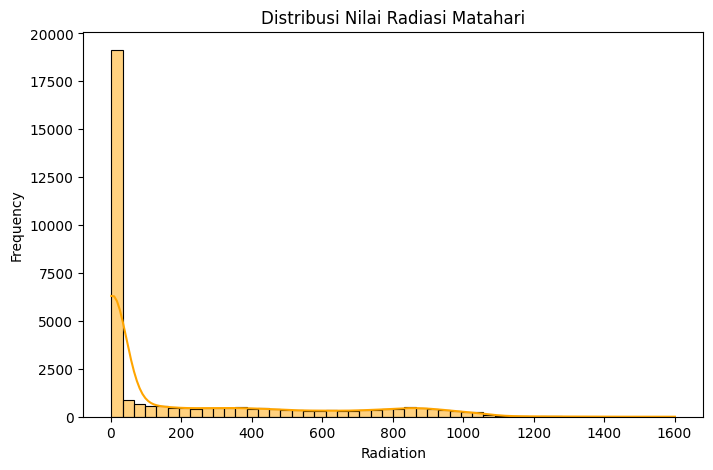

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(df['Radiation'], kde=True, bins=50, color='orange')
plt.title('Distribusi Nilai Radiasi Matahari')
plt.xlabel('Radiation')
plt.ylabel('Frequency')
plt.show()

4. Korelasi Antar Fitur :<br>
Hasil perhitungan matriks korelasi menunjukkan bahwa:
    - Temperature memiliki korelasi positif yang cukup tinggi dengan Radiation (~0.63), yang masuk akal karena suhu biasanya meningkat seiring dengan meningkatnya radiasi matahari.
    - Humidity menunjukkan korelasi negatif terhadap Radiation, yang berarti semakin tinggi kelembaban, semakin rendah kemungkinan intensitas cahaya matahari (karena awan atau uap air menyerap sinar).
    - Fitur lain seperti Pressure, WindDirection, dan Speed menunjukkan korelasi yang lebih lemah terhadap target.

In [28]:
numerical_cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
correlation_matrix = df[numerical_cols].corr()

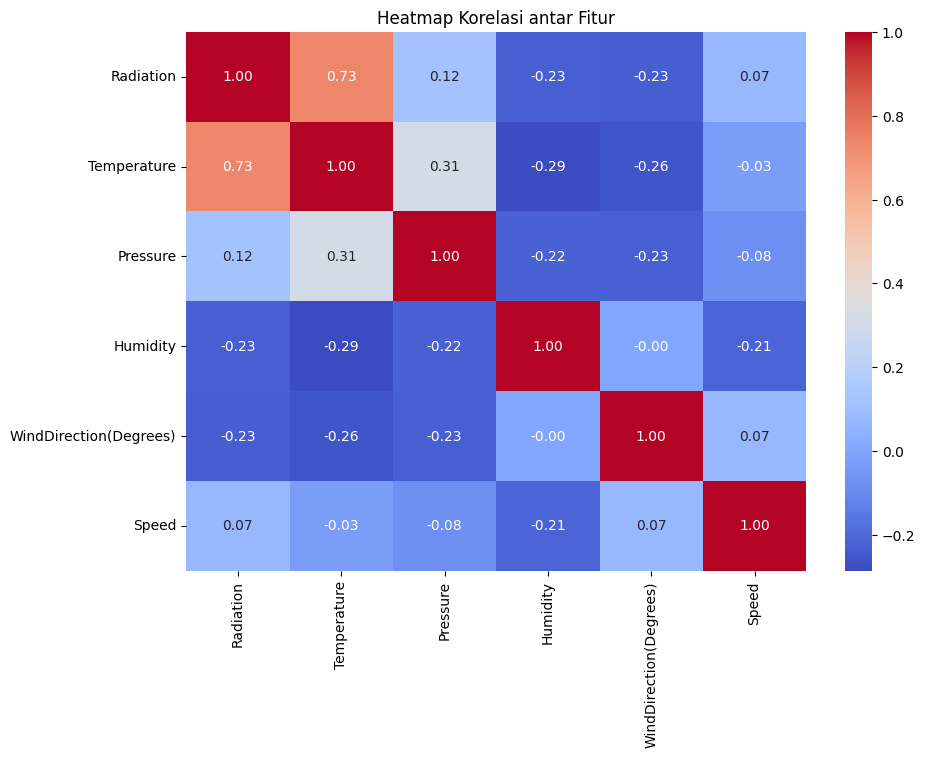

In [29]:
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi antar Fitur')
plt.show()

## Data Preprocessing

1. Seleksi dan Fitur Engineering :<br>
Berdasarkan hasil eksplorasi data (EDA), fitur - fitur yang digunakan selain fitur asli dari dataset seperti Temperature, Humidity, Pressure, WindDirection(Degrees), dan Speed, dilakukan penambahan fitur baru berdasarkan informasi waktu (Time, SunRise, dan SunSet). Fitur tambahan tersebut adalah :
    - SunRiseMinutes : Waktu matahari terbit dalam menit dari pukul 00:00
    - SunSetMinutes : Waktu matahari terbenam dalam menit dari pukul 00:00
    - CurrentMinutes : Waktu saat pengukuran dalam menit dari pukul 00:00
    - MinutesSinceSunRise : Selisih menit antara waktu sekarang dan waktu matahari terbit
    - MinuteUntilSunset : Selisih menit antara waktu matahari terbenam dan waktu sekarang
    - DaylightDuration : Durasi siang hari dalam menit

In [30]:
def time_to_minutes(t):
    return t.hour * 60 + t.minute + t.second / 60
df['Temperature'] = df['Temperature'].astype(float)
df['Humidity'] = df['Humidity'].astype(float)
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format="%H:%M:%S").dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format="%H:%M:%S").dt.time
df['SunRiseMinutes'] = df['TimeSunRise'].apply(time_to_minutes)
df['SunSetMinutes'] = df['TimeSunSet'].apply(time_to_minutes)
df['CurrentMinutes'] = df['Time'].apply(time_to_minutes)
df['MinutesSinceSunrise'] = df['CurrentMinutes'] - df['SunRiseMinutes']
df['MinutesUntilSunset'] = df['SunSetMinutes'] - df['CurrentMinutes']
df['DaylightDuration'] = df['SunSetMinutes'] - df['SunRiseMinutes']
df = df.drop(columns=['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'])

2. Handling Outlier :<br>
Untuk menjaga kualitas data yang masuk ke model, dilakukan normalisasi terhadap nilai - nilai ekstrem (outlier). Penanganan ini penting agar model tidak terdistraksi oleh data yang tidak representatif. Metode yang digunakan adalah clipping berdasarkan distribusi kuartil (IQR)

In [31]:
numeric =  df.select_dtypes(include="number").columns
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom {i} : {len(outlier)} outlier")

Kolom Radiation : 1965 outlier
Kolom Temperature : 89 outlier
Kolom Pressure : 1662 outlier
Kolom Humidity : 0 outlier
Kolom WindDirection(Degrees) : 1618 outlier
Kolom Speed : 479 outlier
Kolom SunRiseMinutes : 0 outlier
Kolom SunSetMinutes : 0 outlier
Kolom CurrentMinutes : 0 outlier
Kolom MinutesSinceSunrise : 0 outlier
Kolom MinutesUntilSunset : 0 outlier
Kolom DaylightDuration : 0 outlier


In [32]:
def outlierhandling(series):
    Q1 = df[series].quantile(0.25)
    Q3 = df[series].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df.loc[df[series] > upper, series] = upper
    df.loc[df[series] < lower, series] = lower
    return df
for i in numeric:
    df = outlierhandling(i)
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom {i} : {len(outlier)} outlier")

Kolom Radiation : 0 outlier
Kolom Temperature : 0 outlier
Kolom Pressure : 0 outlier
Kolom Humidity : 0 outlier
Kolom WindDirection(Degrees) : 0 outlier
Kolom Speed : 0 outlier
Kolom SunRiseMinutes : 0 outlier
Kolom SunSetMinutes : 0 outlier
Kolom CurrentMinutes : 0 outlier
Kolom MinutesSinceSunrise : 0 outlier
Kolom MinutesUntilSunset : 0 outlier
Kolom DaylightDuration : 0 outlier


3. Seleksi Fitur dan Target :<br>
Fitur dan Target yang digunakan dipisah terlebih dahulu pada variabel X sebagai fitur (Temperature, Humidity, Pressure, WindDirection(Degrees), Speed, SunRiseMinutes, SunSetMinutes, CurrentMinutes, MinuteUntilSunset and DaylightDuration) dan y sebagai target (Radiation)
4. Split Data :<br>
Melakukan splitting data menjadi dua yaitu Data training dan data testing yang dibagi sebesar 80:20
5. Normalisasi Fitur :<br>
Untuk memastikan semua fitur memiliki skala yang sebanding, dilakukan normalisasi menggunakan StandardScaler dari sklearn.preprocessing. Metode ini mengubah distribusi fitur agar memiliki mean = 0 dan standard deviation = 1, sehingga mempercepat proses konvergensi model dan menghindari dominasi fitur tertentu.

In [33]:
X = df.drop('Radiation',axis=1)
y = df['Radiation']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling

Model ini merupakan arsitektur Deep Neural Network (DNN) yang dibangun menggunakan Sequential dari Keras. Model terdiri dari beberapa lapisan Dense dengan fungsi aktivasi ReLU dan satu lapisan output untuk regresi.<br>
Langkah kerja model:
- Input Layer menerima fitur sebanyak X_train_scaled.shape[1].
- Hidden Layers: 
    - Lapisan bertingkat dari 32 → 64 → 128 → 256 → 512 neuron.

    - Semua menggunakan aktivasi ReLU untuk menangani vanishing gradient dan meningkatkan non-linearitas model.

- Output Layer: Satu neuron tanpa fungsi aktivasi (linear) karena target bersifat numerik (regresi).
- Optimisasi dilakukan dengan algoritma Adam, loss function menggunakan Mean Squared Error (MSE), dan metrik evaluasi tambahan adalah Mean Absolute Error (MAE).





Pembahasan Parameter
- Dense Neurons: 32, 64, 128, 256, 512 → jumlah neuron bertambah secara progresif untuk menangkap pola kompleks.
- Activation Function: ReLU untuk semua hidden layer (default).
- Output Activation: Linear (default, tanpa aktivasi).
- Optimizer: Adam (default setting).
- Loss Function: mse (default untuk regresi).
- Metrics: mae untuk interpretasi performa model.

In [34]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1)
])
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
model.summary()

d:\Dicoding\Predictive-Analytic\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,937 (687.25 KB)

 Trainable params: 175,937 (687.25 KB)

 Non-trainable params: 0 (0.00 B)

Callbacks yang digunakan:
- EarlyStopping(patience=5, restore_best_weights=True): menghentikan training jika tidak ada perbaikan dalam 5 epoch.
- ReduceLROnPlateau: menurunkan learning rate jika val_loss stagnan.
- ModelCheckpoint: menyimpan model terbaik berdasarkan val_loss.

In [35]:
callback = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6,verbose=1),
    ModelCheckpoint(filepath='../models/best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

In [36]:
history = model.fit(X_train_scaled,y_train, validation_split=0.2, batch_size=64, epochs=100, callbacks=[callback])

Epoch 1/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63428.7266 - mae: 154.8642
Epoch 1: val_loss improved from inf to 15321.08008, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 63071.6602 - mae: 154.2837 - val_loss: 15321.0801 - val_mae: 67.3245 - learning_rate: 0.0010
Epoch 2/100
321/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13940.3916 - mae: 62.6119
Epoch 2: val_loss improved from 15321.08008 to 10968.79688, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13921.1338 - mae: 62.5568 - val_loss: 10968.7969 - val_mae: 53.9444 - learning_rate: 0.0010
Epoch 3/100
317/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10960.0361 - mae: 54.0916
Epoch 3: val_loss improved from 10968.79688 to 9867.43359, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10954.4531 - mae: 54.0721 - val_loss: 9867.4336 - val_mae: 50.4194 - learning_rate: 0.0010
Epoch 4/100
320

Kelebihan/Kekurangan<br>
Kelebihan:
- Arsitektur deep yang fleksibel untuk menangkap pola kompleks.
- Callbacks mencegah overfitting dan meningkatkan efisiensi training.
Kekurangan:
- Rentan overfitting tanpa regularisasi tambahan.
- Memerlukan data dalam jumlah besar untuk hasil optimal.

## Evaluation

Metrik Evaluasi<br>
Pada proyek ini digunakan dua metrik utama untuk mengevaluasi performa model regresi:

- Mean Absolute Error (MAE): Mengukur rata-rata selisih absolut antara nilai prediksi dengan nilai aktual. Metrik ini cocok untuk mengetahui seberapa jauh rata-rata prediksi meleset dari nilai sebenarnya tanpa penalti besar terhadap outlier.

- Mean Squared Error (MSE): Memberikan penalti lebih besar terhadap error yang besar (kuadrat dari selisih), sehingga cocok untuk mendeteksi prediksi yang jauh melenceng.

Kedua metrik dipilih karena mampu memberikan gambaran menyeluruh tentang kualitas prediksi model regresi, terutama dalam konteks prediksi radiasi matahari yang membutuhkan presisi tinggi.



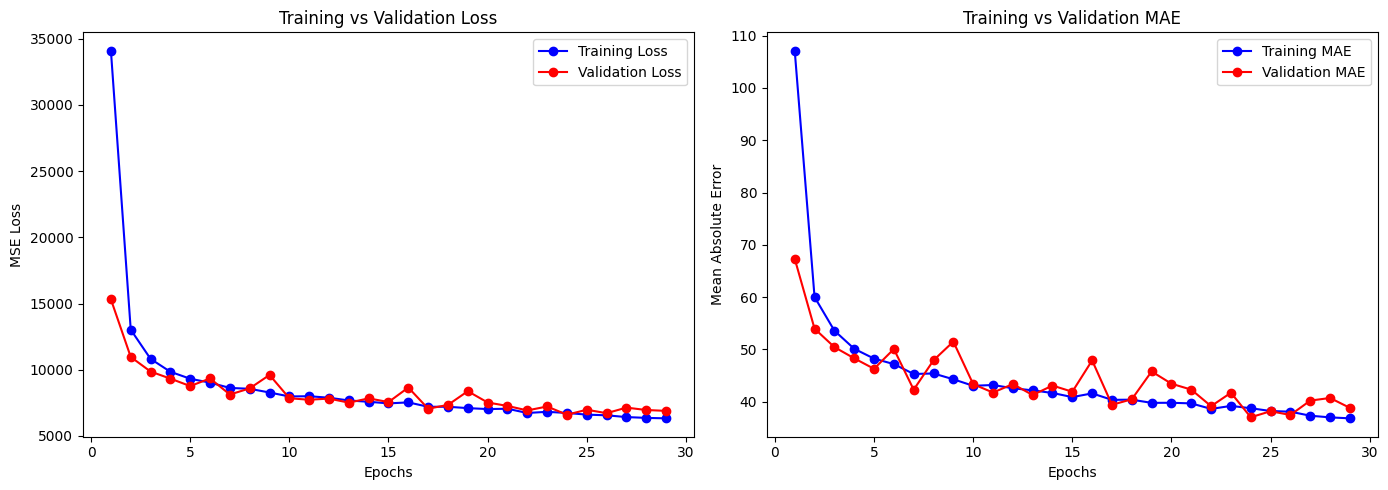

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
val_mae = history.history['val_mae'][-1]
mae_percent = (val_mae / y_test.mean()) * 100
print(f"MAE sekitar {mae_percent:.2f}% dari rata-rata radiation")

MAE sekitar 19.64% dari rata-rata radiation


Paparkan Hasil Evaluasi<br>
Berdasarkan hasil training dengan model terbaik (dengan arsitektur dense 6-layer), diperoleh hasil evaluasi sebagai berikut:

- MAE Validation (akhir): val_mae = {val_mae}

- Rata-rata nilai aktual radiasi: y_test.mean() = {y_test.mean()}

- Persentase MAE terhadap rata-rata:
→ Model menghasilkan MAE sekitar {mae_percent:.2f}% dari rata-rata nilai aktual, yang menunjukkan bahwa model memiliki akurasi prediksi yang cukup baik untuk kebutuhan analisis radiasi matahari.

Visualisasi juga memperkuat hasil evaluasi melalui grafik berikut:

- Grafik Training vs Validation Loss (MSE)
- Grafik Training vs Validation MAE

Keduanya menunjukkan bahwa model tidak mengalami overfitting yang signifikan dan stabil selama proses pelatihan.

Apakah sudah menjawab setiap problem statement?<br>
✅ Ya. Model berhasil menjawab tantangan terbatasnya sistem prediksi radiasi matahari dengan membangun arsitektur deep learning berbasis data historis meteorologi. Selain itu, eksperimen ini menyediakan benchmark awal untuk model prediksi berbasis deep learning pada dataset terbuka.

Apakah berhasil mencapai setiap goals?<br>
✅ Ya. Tujuan untuk membangun sistem prediksi dan menyediakan baseline performa sudah tercapai. Model dapat digunakan sebagai titik awal pengembangan sistem energi surya berbasis prediksi.

Apakah setiap solusi statement yang direncanakan berdampak?<br>
✅ Ya.

- Solusi pengembangan model deep learning berhasil menghasilkan performa yang baik.

- Hyperparameter tuning mampu meningkatkan performa.

- Evaluasi menggunakan MAE & MSE memberikan validasi yang kuat bahwa model dapat digunakan untuk skenario dunia nyata.